# Redes neuronales convolucionales: paso a paso

Esta es la primera tarea del Curso 4. En esta tarea se implementan capas de convolución (CONV) y de pooling (POOL) en numpy, incluyendo tanto el fordward propagation como el backward propagation.

Al final de este cuaderno, serás capaz de:

* Explicar la operación de convolución.
* Aplicar dos tipos diferentes de operaciones de agrupamiento.
* Identificar los componentes utilizados en una red neuronal convolucional (padding, stride, filtro, ...) y su propósito.
* Construir una red neuronal convolucional.

::: {.callout-tip title="**Notación**" collapse="true"}
* El superíndice $[l]$ denota un objeto de la $l^{th}$ capa.

    - Ejemplo: $a^{[4]}$ es la activación de la cuarta capa. $W^{[5]}$ y $b^{[5]}$ son los parámetros de la quinta capa.

* El superíndice $(i)$ denota un objeto del $i^{th}$ ejemplo.

    - Ejemplo: $x^{(i)}$ es la entrada del $i^{th}$ ejemplo de entrenamiento.

* El subíndice $i$ denota la $i^{th}$ entrada de un vector.

    - Ejemplo: $a^{[l]}_i$ denota la $i^{th}$ entrada de las activaciones en la capa $l$, asumiendo que esta es una capa fully connected (FC).

* $n_H$, $n_W$ y $n_C$ denotan respectivamente la altura, anchura y número de canales de una capa dada. Si quieres referirte a una capa específica $l$, también puedes escribir $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$.

* $n_{H_{prev}}$, $n_{W_{prev}}$ y $n_{C_{prev}}$ denotan respectivamente la altura, anchura y número de canales de la capa anterior. Si se hace referencia a una capa específica $l$, esto también podría denotarse como $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$
:::

## Contenidos

- [1 - Librerías](#1)
- [2 - Convolutional Neural Networks](#2)
    - [2.1 - Zero-Padding](#2-1)
        - [Exercise 1 - zero_pad](#ex-1)
    - [2.2 - Single Step of Convolution](#2-2)
        - [Exercise 2 - conv_single_step](#ex-2)
    - [2.3 - Convolutional Neural Networks - Forward Pass](#2-3)
        - [Exercise 3 - conv_forward](#ex-3)


<a name='1'></a>

## 1 - Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


np.random.seed(1)

<a name='2'></a>

## 2 - Convolutional Neural Networks

Una capa de convolución transforma un volumen de entrada en un volumen de salida de tamaño diferente, como se muestra a continuación:

<p align="center">
    <img src="images/conv_nn.png" style="width:350px;height:200px;">
</p>

En esta parte, se construirán todos los pasos de la capa de convolución. Se comenzará implementando dos funciones auxiliares:  una para el zero-padding y otra para calcular la función de convolución en sí.

<a name='2-1'></a>

### 2.1 - Zero-Padding

<p align="center">
  <img src="images/PAD.png" style="width:600px;height:400px;">
  <caption><center>
    <u> 
      <b style='color: purple;'>Figure 1:</b>
    </u> 
    <span style='color: purple;'><b>Zero-Padding</b><br> Image (3 channels, RGB) with a padding of 2.</span>
  </center></caption>
</p>

Los principales beneficios del padding son:

Permite utilizar una capa CONV sin reducir necesariamente la altura y el ancho de los volúmenes. Esto es importante para construir redes más profundas, ya que de lo contrario, la altura y el ancho disminuirían al avanzar hacia capas más profundas. Un caso especial importante es la convolución "same", en la que la altura y el ancho se preservan exactamente después de una capa.

Ayuda a conservar más información en el borde de una imagen. Sin relleno, muy pocos valores en la capa siguiente se verían afectados por los píxeles en los bordes de una imagen.

<a name='ex-1'></a>

### Ejercicio 1 - zero_pad
Se debe implementar la siguiente función, que añade zero-padding a todas las imágenes de un batch de ejemplos X. 

Por ejemplo, si se desea añadir un relleno de pad = 1 para la segunda dimensión, pad = 3 para la cuarta dimensión y pad = 0 para el resto a un array "a" de forma $(5,5,5,5,5)$, se haría de la siguiente manera:

```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))
```


In [2]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
    
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)))
      
    return X_pad

Dimensiones del vector x: 	(4, 3, 3, 2)
Dimensiones del vector x_pad: 	(4, 3, 3, 2)

Contenido de x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]

Contenido de x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


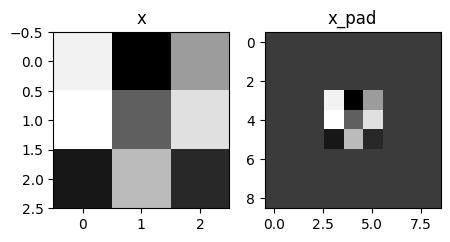

In [3]:
# genero vector de números aleatorios (4 matrices de 3x3 con 2 canales)
x = np.random.randn(4, 3, 3, 2)

# le añado el padding (El tamaño del relleno es 3, lo que significa que se añaden 3 filas/columnas de ceros alrededor de cada matriz)
x_pad = zero_pad(x, 3)

print (f"Dimensiones del vector x: \t{x.shape}")
print (f"Dimensiones del vector x_pad: \t{x.shape}")

print ("\nContenido de x[1,1] =\n", x[1, 1])
print ("\nContenido de x_pad[1,1] =\n", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])
plt.show()

In [4]:
x[1,:,:,:]

array([[[ 0.04221375,  0.58281521],
        [-1.10061918,  1.14472371],
        [ 0.90159072,  0.50249434]],

       [[ 0.90085595, -0.68372786],
        [-0.12289023, -0.93576943],
        [-0.26788808,  0.53035547]],

       [[-0.69166075, -0.39675353],
        [-0.6871727 , -0.84520564],
        [-0.67124613, -0.0126646 ]]])

<a name='2-2'></a>

### 2.2 - Un solo paso de la convolución

En esta parte, se implementará un solo paso de la convolución, en el cual se aplciará el filtro a una única posición de la entrada. Esto se utilizará para construir una unidad convolucional, que:

- Toma un volumen de entrada
- Aplica un filtro en cada posición de la entrada
- Produce otro volumen (generalmente de tamaño diferente)

<p align="center">
  <img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
  <caption><center>
    <u> 
      <b style="color: purple;">Figura 2:</b>
    </u> 
    <span style='color: purple;'><b>Operación de convolución</b><br> Operación de convolución con un filtro de 3x3 y un paso de 1 (el paso es la cantidad que mueves la ventana cada vez que la deslizas)</span>
  </center></caption>
</p>

En una aplicación de computer vision, cada valor en la matriz de la izquierda corresponde a un solo valor de píxel. Se convoluciona un filtro de 3x3 con la imagen multiplicando sus valores elemento a elemento (element-wise) con la matriz original, luego sumándolos y añadiendo un sesgo (bias). En este primer paso, se implementa un solo paso de la convolución, correspondiente a aplicar un filtro a solo una de las posiciones para obtener una única salida de valor real.


<a name='ex-2'></a>

### Ejercicio 2 - conv_single_step
Implementa `conv_single_step()`.

In [5]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev,W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    b = np.squeeze(b)
    Z = Z + b
    
    return Z

In [6]:
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = 0.35608282827551285


<a name='2-3'></a>

### 2.3 - Convolutional Neural Networks - Forward Pass

En el forward pass, se convolucionan múltiples filtros sobre la entrada. Cada 'convolución' proporciona una salida en forma de matriz 2D. Estas salidas se apilan para obtener un volumen 3D:

<center>
<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<a name='ex-3'></a>

### Exercise 3 -  conv_forward
Se implementará la función a continuación para convolucionar los filtros W sobre una activación de entrada A_prev.
Esta función toma los siguientes parámetros:

* `A_prev`, las activaciones producidas por la capa anterior (para un batc de $m$ entradas);
* Los pesos se denotan con `W`. El tamaño de la ventana del filtro es $f x f$ .
* El vector de sesgo es `b`, donde cada filtro tiene su propio sesgo (único).
También se tiene acceso al diccionario de hiperparámetros, que contiene el paso (stride) y el relleno (padding).


::: {.callout-tip title="**Hint**" collapse="true"}
**Hint**: 
1. Para seleccionar una porción 2x2 en la esquina superior izquierda de una matriz "a_prev" (de forma (5,5,3)), se haría:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
Notese cómo esto da una porción 3D que tiene altura 2, ancho 2 y profundidad 3. La profundidad es el número de canales.

Esto será útil cuando se defina `a_slice_prev` a continuación, utilizando los índices `start/end` que se definirán.

2. Para definir a_slice se necesitará primero definir sus esquinas `vert_start`, `vert_end`, `horiz_start` y `horiz_end`. La siguiente figura puede ser útil para descubrir cómo cada una de las esquinas puede ser definida usando $h$, $w$, $f$ y $s$ en el código a continuación.


<p align="center">
    <img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
    <caption><center> 
        <u> 
            <b style="color: purple;">Figura 3:</b> 
        </u>
        <span style='color: purple;'><b>Definition of a slice using vertical and horizontal start/end (with a 2x2 filter)</b> <br> This figure shows only a single channel.  
    </center></caption>
</p>

**Reminder**:
    
Las fórmulas que relacionan la forma de salida de la convolución con la forma de entrada son:
    
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{número de filtros en la convolución}$$
    
:::


Para este ejercicio se implementará todo con bucles for.

In [7]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. (≈2 lines)
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]          # Select ith training example's padded activation
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = stride * h 
            vert_end = vert_start  + f
            
            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" (≈2 lines)
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    weights = W[:, :, :, c]
                    biases  = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [9]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("\nZ's mean =\t", np.mean(Z))
print("\nZ[0,2,1] =\n", Z[0, 2, 1])
print("\ncache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])



Z's mean =	 0.5511276474566768

Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]

cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


<a name='4'></a>

## 4 - Pooling Layer 

La capa de pooling (POOL) reduce la altura y el ancho de la entrada. Contribuye a la reducción del cálculo, así como a la invariancia de los detectores de características frente a su posición en la entrada. Existen dos tipos de capas de pooling:

- **Max-pooling layer**: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- **Average-pooling layer**: slides an ($f, f$) window over the input and stores the average value of the window in the output.

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

Estas cpasa de pooling no tienen parámetros que entrenar durante el backpropagation, pero si tienen hiperparámetros como el `window size` $f$, que especifica la altura y ancho de la ventana $f \times f$ sobre la cual se calcula el máximo o el promedio (*max* o *average*). 

<a name='4-1'></a>

### 4.1 - Forward Pooling

En la sección se implementarán tanto el MAX-POOL como el AVG-POOL dentro de la misma función.

<a name='ex-4'></a>

### Exercise 4 - pool_forward

**Reminder**:
Como aquí no hay padding, las fórmulas que relacionan la forma de salida del agrupamiento con la forma de entrada son las siguientes:

$$\text{ancho de salida, } n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$\text{ancho de salida, }n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$\text{número de canales de salida, }n_C = n_{C_{prev}}$$


In [10]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    ### START CODE HERE ###
    for i in range(m):                         # loop over the training examples
        a_prev_slice = A_prev[i]
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = stride * h 
            vert_end = vert_start + f
            
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_slice_prev = a_prev_slice[vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_slice_prev)
                    else:
                        print(mode+ "-type pooling layer NOT Defined")    
    # YOUR CODE ENDS HERE
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [16]:
# Case 1: stride of 1
np.random.seed(1)

A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters, mode = "max")
print("Max pooling:")
print("\nA.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("Average pooling:")
print("\nA.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])


Max pooling:

A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]

Average pooling:

A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]


In [17]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("Max pooling:")
print("\nA.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("Average pooling:")
print("\nA.shape = " + str(A.shape))
print("A[1] =\n", A[1])

Max pooling:

A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

Average pooling:

A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]


**Lecciones**

* Una convolución extrae características de una imagen de entrada tomando el dot product entre los datos de entrada y un array 3D de pesos (el filtro).
* El resultado 2D de la convolución se denomina **feature map**.
* Una capa de convolución es donde el filtro se desliza sobre la imagen y calcula el dot product.
    * Esto transforma el volumen de entrada en un volumen de salida de tamaño diferente.
* El zero-padding ayuda a conservar más información en los bordes de la imagen y es útil para construir redes más profundas, ya que se puede construir una capa CONV sin reducir la altura y el ancho de los volúmenes.
* Las pooling layers reducen gradualmente la altura y el ancho de la entrada deslizando una ventana 2D sobre cada región especificada, luego resumiendo las características en esa región.

<a name='5'></a>

## 5 - Backpropagation en las Convolutional Neural Networks 

En los frameworks de deep learning, solo se necesita implementar el forward pass, y el framework se encarga del backpropagation, por lo que la mayoría de los ingenieros de deep learning no necesitan preocuparse por susdetalles.

Cuando se implementa una red neuronal simple (fully-connected), se utiliza la retropropagación para calcular las derivadas con respecto al loss para actualizar los parámetros. De manera similar, en las redes neuronales convolucionales se pueden calcular las derivadas con respecto al costo para actualizar los parámetros. Las ecuaciones de retropropagación se presentan brevemente a continuación.

<a name='5-1'></a>

### 5.1 - Convolutional Layer Backward Pass 

Comencemos implementando el paso hacia atrás para una capa CONV.

<a name='5-1-1'></a>

#### 5.1.1 - Cálculo de $dA$:

This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$dA \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

Donde $W_c$ es un filtro y $dZ_{hw}$ un escalar correspondiente al gradiente del loss con respecto a la salida de la capa convolucional $Z$ en la fila $h$ y columna $w$ (correspondiente al dot-product tomado en el desplazamiento $i$ hacia la izquierda y el desplazamiento $j$ hacia abajo). Notese que en cada momento, se multiplica el mismo filtro $W_c$ por un $dZ$ diferente al actualizar $dA$. Esto se debe pricipalmente a que cuanto se calcula el forward pass, cada filtro realiza el dot-product y es sumado por un $a_{slice}$ distinto. Por lo tanto, al calcular el backpropagation para $dA$, simplemente se estan sumando los gradientes de todos los $a_{slices}$. 

En código, dentro de los bucles for apropiados, esta fórmula se traduce en:
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

<a name='5-1-2'></a>

#### 5.1.2 - Cálculo de $dW$:

Esta es la fórmula para calcular $dW_c$ (donde $dW_c$ es la derivada de un filtro) con respecto al loss:

$$dW_c  \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

Donde $a_{slice}$ corresponde a la porción que se utilizó para generar la activación $Z_{ij}$. Por lo tanto, esto nos da el gradiente para $W$con respecto a esa porción. Dado que es el mismo $W$, simplemente se sumarán todos esos grandientes para obtener $dW$. 

En código, dentro de los bucles for apropiados, esta fórmula se traduce en:
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

<a name='5-1-3'></a>

#### 5.1.3 - Cálculo de $db$:

Esta es la fórmula para calcular $db$ con respecto al costo para un cierto filtro $W_c$:

$$db = \sum_h \sum_w dZ_{hw} \tag{3}$$
Al igual que en el caso de las redes básicas, $db$ se calcula sumando $dZ$. En este caso, simplemente se están sumando todos los gradientes de la salida convolucional ($Z$) con respecto al loss.

En código, dentro de los bucles for apropiados, esta fórmula se traduce en:
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

<a name='ex-5'></a>

### Exercise 5 - conv_backward

A continuación, se implementa la función `conv_backward`. You should sum over all the training examples, filters, heights, and widths. You should then compute the derivatives using formulas 1, 2 and 3 above. 

In [18]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """    
    
        
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros(A_prev.shape)                          
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape) # b.shape = [1,1,1,n_C]
    
    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = stride * h 
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f

                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpadded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [19]:
# We'll run conv_forward to initialize the 'Z' and 'cache_conv",
# which we'll use to test the conv_backward function
np.random.seed(1)

A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


<a name='5-2'></a>

## 5.2 Pooling Layer - Backward Pass

A continuación, se implementará el backward pass para la pooling layer, empezando por la capa MAX-POOL. Aunque una capa pooling no tiene parámetros que actualizar en la fase de retropropagación, aún es necesario retropropagar el gradiente a través de la la pooling layer para calcular los gradientes de las capas que precedieron a la capa de pooling. 

<a name='5-2-1'></a>

### 5.2.1 Max Pooling - Backward Pass  

Antes de saltar directamente al backpropagation de la capa de pooling, se va a contruir la función de ayuda `create_mask_from_window()`, que hace lo siguiente: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

La función `create_mask_from_window()` genera una matriz "máscara" que identifica la ubicación del valor máximo dentro de una matriz. Un True (1) en la máscara indica la posición del máximo en la matriz X, mientras que todas las demás entradas son False (0). El average pooling durante la retropropagación opera de manera similar, aunque con una máscara distinta.


<a name='ex-6'></a>
### Exercise 6 - create_mask_from_window

Se implementa la función `create_mask_from_window()`. Esta función será de ayuda durante el pooling de la retropropagación.


In [20]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """    

    mask = (x == np.max(x))
    
    return mask

In [23]:
np.random.seed(1)

x = np.random.randn(2, 3)
mask = create_mask_from_window(x)
print('x = \n', x)
print("mask = \n", mask)

x = np.array([[-1, 2, 3],
              [2, -3, 2],
              [1, 5, -2]])

y = np.array([[False, False, False],
     [False, False, False],
     [False, True, False]])

mask = create_mask_from_window(x)

x = 
 [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask = 
 [[ True False False]
 [False False False]]


Se realiza el seguimiento de la posición del valor máximo porque es este valor de entrada el que finalmente influye en el resultado y, por tanto, en el costo. El proceso de retropropagación calcula los gradientes con respecto al costo, por lo que **cualquier elemento que influya en el costo final debe tener un gradiente no nulo**. Por tanto, la retropropagación "propagará" el gradiente de vuelta al valor de entrada específico que influyó en el costo.

<a name='5-2-2'></a>

### 5.2.2 - Average Pooling - Backward Pass 

En el max pooling, para cada ventana de entrada, toda la "influencia" en el resultado proviene de un único valor de entrada: el máximo. En el average pooling, cada elemento de la ventana de entrada tiene la misma influencia en el resultado. Por lo tanto, para implementar la retropropagación, ahora se implementará una función auxiliar que refleje esto.

Por ejemplo, si se realizó un average pooling en el forward pass utilizando un filtro de 2x2, entonces la máscara que se utilizará para la retropropagación será así:
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

Esto implica que cada posición en la matriz $dZ$ contribuye de manera igual al resultado porque, en el forward pass, se toma un promedio.

<a name='ex-7'></a>

### Exercise 7 - distribute_value

A continuación se implementa la función `distribute_value` para distribuir equitativamente un valor dz a través de una matriz de dimensión shape.

In [24]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """    
    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = np.prod(shape)
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    a = (dz/average)*np.ones(shape)

    return a

In [26]:
a = distribute_value(2, (2, 2))
print('distributed value =\n', a)

distributed value =
 [[0.5 0.5]
 [0.5 0.5]]


<a name='5-2-3'></a>

### 5.2.3 Putting it Together: Pooling Backward 

Ahora se dispoonen de todos los elementos para calcular el back propagation en una pooling layer.

<a name='ex-8'></a>

### Exercise 8 - pool_backward

Se implementa la función `pool_backward` en ambos modos (`"max"` and `"average"`). Nuevamente, se utilizan 4 bucles for (iterando sobre los ejemplos de entrenamiento, altura, anchura y canales). Se emprea un `if/elif` para verificar si el modo es igual a `'max'` o `'average'`. Si es igual a 'average' se usa la función `distribute_value()` implementada anteriormente para crear una matriz de la misma dimensión que `a_slice`. De lo contrario, si el mdoo es igual a '`max`', se crea una máscara con `create_mask_from_window()` y se multiplica por el valor correspondiente de $dA$.

In [ ]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m): # loop over the training examples
        
        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i,:,:,:]
        
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
        
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start  = h * stride
                    vert_end    = h * stride + f
                    horiz_start = w * stride
                    horiz_end   = w * stride + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[ vert_start:vert_end, horiz_start:horiz_end, c ]
                        
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window( a_prev_slice )

                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]
                        
                    elif mode == "average":
                        
                        # Get the value da from dA (≈2 line)
                        da = dA[i, h, w, c]
                        
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f,f)

                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev